# HOP 336 – Cycle 25 activity bands with Hinode & IRIS

This notebook develops the analysis of the [HOP 336 data](http://www.isas.jaxa.jp/home/solar/hinode_op/hop.php?hop=0336).  This dataset observed the high-latitude activity bands in the northern and southern solar hemispheres at a $\sim$1 week cadence.  The goals are:

 * Identify and quantify time-trends in magnetic field & spectral irradiance in these bands, as Cycle 25 progresses
 * Identify and characterize the magnetic structures below the coronal bright points observed with SDO/AIA
 
Useful references:

 * McIntosh et al. 2014
 * Bellot Rubio and Orozco Suárez 2019, "Quiet Sun magnetic fields: an observational view." LRSP
 * Lites et al. 2008, "The Horizontal Magnetic Flux of the Quiet-Sun INternetwork as Observed with the Hinode Spectro-polarimeter." ApJ 672:I237-1253

In [1]:
import numpy as np
import astropy.io.fits
import matplotlib as mpl
import matplotlib.animation
from matplotlib import pyplot as plt
import IPython.display

import astropy.units as u
import astropy.coordinates
import sunpy.coordinates.frames

import os
import os.path

In [2]:
plt.rc('axes.formatter', useoffset=False)

In [302]:
NOISE_THRESH = 200
NOISE_THRESH_FAST = 178 # Rebecca's noise analysis, 3-sigma
NOISE_THRESH_NORMAL = 214 # Rebecca's noise analysis, 3-sigma

In [303]:
datadir = "north"
allfiles = [os.path.join(datadir, f) for f in sorted(os.listdir(datadir))]
example_file = allfiles[0]
SP_level2 = astropy.io.fits.open(example_file)
SP_level2.info()
print(SP_level2[0].header)

Filename: north/20170307_105707.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  Field_Strength    1 ImageHDU         8   (2034, 512)   float32   
  2  Field_Inclination    1 ImageHDU         8   (2034, 512)   float32   
  3  Field_Azimuth    1 ImageHDU         8   (2034, 512)   float32   
  4  Doppler_Shift1    1 ImageHDU         8   (2034, 512)   float32   
  5  Doppler_Shift2    1 ImageHDU         8   (2034, 512)   float32   
  6  Doppler_Width    1 ImageHDU         8   (2034, 512)   float32   
  7  Line_Strength    1 ImageHDU         8   (2034, 512)   float32   
  8  Damping       1 ImageHDU         8   (2034, 512)   float32   
  9  Source_Function    1 ImageHDU         8   (2034, 512)   float32   
 10  Source_Function_Gradient    1 ImageHDU         8   (2034, 512)   float32   
 11  Macro_Turbulence    1 ImageHDU         8   (2034, 512)   float32   
 12  Stray_Light_Fill_Factor    1 ImageHDU         8   (2034

 [astropy.io.fits.verify]


## Check Pixel Scale

xscale: 0.28935242 0.297139
yscale: 0.3199768 0.319978
XCEN, YCEN: -33.5985 446.193
corner (0, 0) => (-185.4600372314453, 365.1631164550781)
corner (0, -1) => (118.26300048828125, 364.318115234375)
corner (-1, 0) => (-185.4600372314453, 528.6729125976562)
corner (-1, -1) => (118.26300048828125, 527.827880859375)
X Corners: -185.46004 118.263 -185.46004 118.263
Y Corners: 365.16312 364.3181 528.6729 527.8279


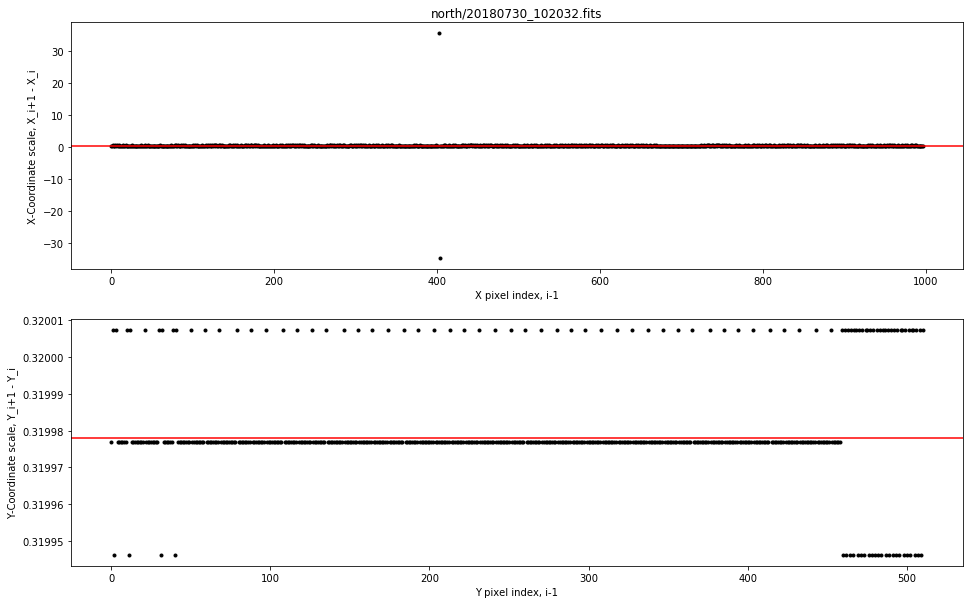

In [304]:
# Check the pixel scale metadata
# ix 80: fast map
# ix 100: normal map
filepath = allfiles[80]
basename = os.path.basename(filepath)
SP_level2 = astropy.io.fits.open(filepath)
X = SP_level2[38].data
Y = SP_level2[39].data
XSCALE = SP_level2[0].header['XSCALE']
YSCALE = SP_level2[0].header['YSCALE']
print("xscale:", X[0,1] - X[0,0], XSCALE)
print("yscale:", Y[1,0] - Y[0,0], YSCALE)
print("XCEN, YCEN:", SP_level2[0].header['XCEN'], SP_level2[0].header['YCEN'] )
for ixs in ((0,0), (0,-1), (-1,0), (-1,-1)):
    print(f"corner {ixs} => ({X[ixs]}, {Y[ixs]})")
print("X Corners:", X[(0,0)], X[0,-1], X[-1,0], X[-1,-1])
print("Y Corners:", Y[0,0], Y[0,-1], Y[-1,0], Y[-1,-1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10))
ax1.plot(X[0,1:] - X[0,0:-1], 'k.')
ax1.axhline(XSCALE, c='r')
ax1.set_ylabel('X-Coordinate scale, X_i+1 - X_i')
ax1.set_xlabel('X pixel index, i-1')
ax1.set_title(filepath)

ax2.plot(Y[1:,0] - Y[0:-1,0], 'k.')
ax2.axhline(YSCALE, c='r')
ax2.set_ylabel('Y-Coordinate scale, Y_i+1 - Y_i')
ax2.set_xlabel('Y pixel index, i-1')

plt.savefig(basename + "_scale.pdf", bbox_inches='tight')

### TODO Pixel Scale

 * what should I believe, the (XSCALE, YSCALE), or the (X_Coordinate, Y_Coordiante)?
 * The difference X_i+1 - X_i appears to differ depending on i.  Differences can be extreme.  Why?
   * Is this some kind of jitter?
 * Y-Coordinate differences bounce between two values, close to the YSCALE

# B magnitude histograms

roughmode: 75.000 modepeak: 74.494
roughmode: 75.000 modepeak: 74.494


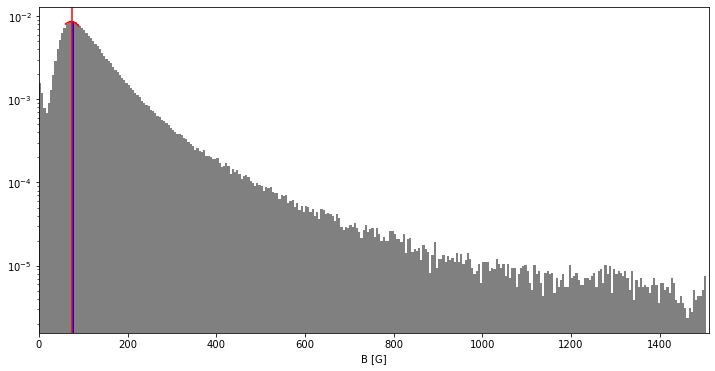

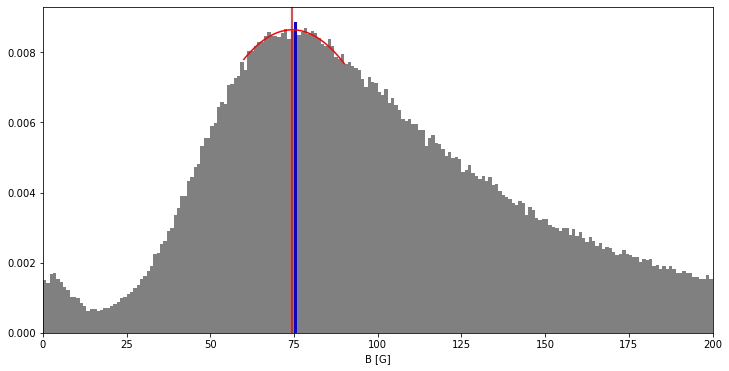

In [293]:
def is_fast(SP_level2):
    xscale = SP_level2[0].header['XSCALE']
    if xscale > 0.20:
        return True
    else:
        return False

def get_B(SP_level2):
    B = SP_level2[1].data
    Binc = SP_level2[2].data
    Bazi = SP_level2[3].data
    return B, Binc, Bazi

def mode(x, binsize=1., extent=500.):
    """Compute the mode of a distribution with a given binsize"""
    bins = np.arange(0., extent + binsize, binsize)
    hist, bin_edges = np.histogram(x, bins)
    ix_max = np.argmax(hist)
    return bins[ix_max]

def modepeak(x, binsize=1., extent=500., range_pct=0.2):
    """Fit the peak of a distribution of a given binsize"""
    bins = np.arange(0., extent + binsize, binsize)
    hist, bin_edges = np.histogram(x, bins)
    ix_max = np.argmax(hist)
    mode = bins[ix_max]
    lo = mode * (1-range_pct)
    hi = mode * (1+range_pct)
    bins = bins[0:-1]
    sel = (bins >= lo) & (bins <= hi)
    p = np.polyfit(bins[sel], hist[sel], 2)
    p1d = np.poly1d(p)
    dp1d = np.polyder(p1d)
    roots = np.roots(dp1d.c)
    mode = roots[0]
    return mode
    
def hist_B(SP_level2, log=True, extent=1500, binsize=5, xlim=None, range_pct=0.2):
    B, Binc, Bazi = get_B(SP_level2)
    fig, ax = plt.subplots(figsize=(12,6))
    bins = np.arange(0, +extent + 2*binsize, binsize)
    N, bins, patches = ax.hist(B.ravel(), bins=bins, density=True, color='gray');
    mode_ix = np.argmax(N)
    patches[mode_ix].set_facecolor('b')
    roughmode = bins[mode_ix]
    B_mode = modepeak(B)
    print(f"roughmode: {roughmode:0.3f} modepeak: {B_mode:0.3f}")
    ax.axvline(B_mode, c='r')
    bins = bins[0:-1]
    lo = roughmode * (1-range_pct)
    hi = roughmode * (1+range_pct)
    sel = (bins >= lo) & (bins <= hi)
    p = np.polyfit(bins[sel], N[sel], 2)
    p1d = np.poly1d(p)
    dp1d = np.polyder(p1d)
    roots = np.roots(dp1d.c)
    mode = roots[0]
    ax.plot(bins[sel], p1d(bins[sel]), 'r-')
    if log:
        ax.set_yscale('log')
    ax.set_xlabel('B [G]')
    if xlim is None:
        xlim = extent + 2*binsize
    ax.set_xlim(0, xlim)

# ix 80: fast map
# ix 100: normal map
SP_level2 = astropy.io.fits.open(allfiles[80])
hist_B(SP_level2)
hist_B(SP_level2, binsize=1, xlim=200, log=False)

### TODO noise removal

  * <strike>Threshold of 20-30 G looks like the noise level</strike>
    * R. Centeno says that 100 G is appropriate noise level for vector B; 20-30 makes sense for B_LOS
    * Is the turnaround in the histogram indicative of the noise level?
  * Rigorously find noise level by inflection point in PDF
    * Is this a good method?  See above.
    * Or maybe deviation in a PDF model fit
    * Or use Q or U exceeding 4.5x the noise level (Orozco Suárez and Bellot Rubio (2020)

# Chi Squared

N_sel=437 (0.086%)
N_sel=510976 (100.000%)
N_sel=460216 (90.066%)
N_sel=478874 (93.718%)
N_sel=446083 (87.300%)


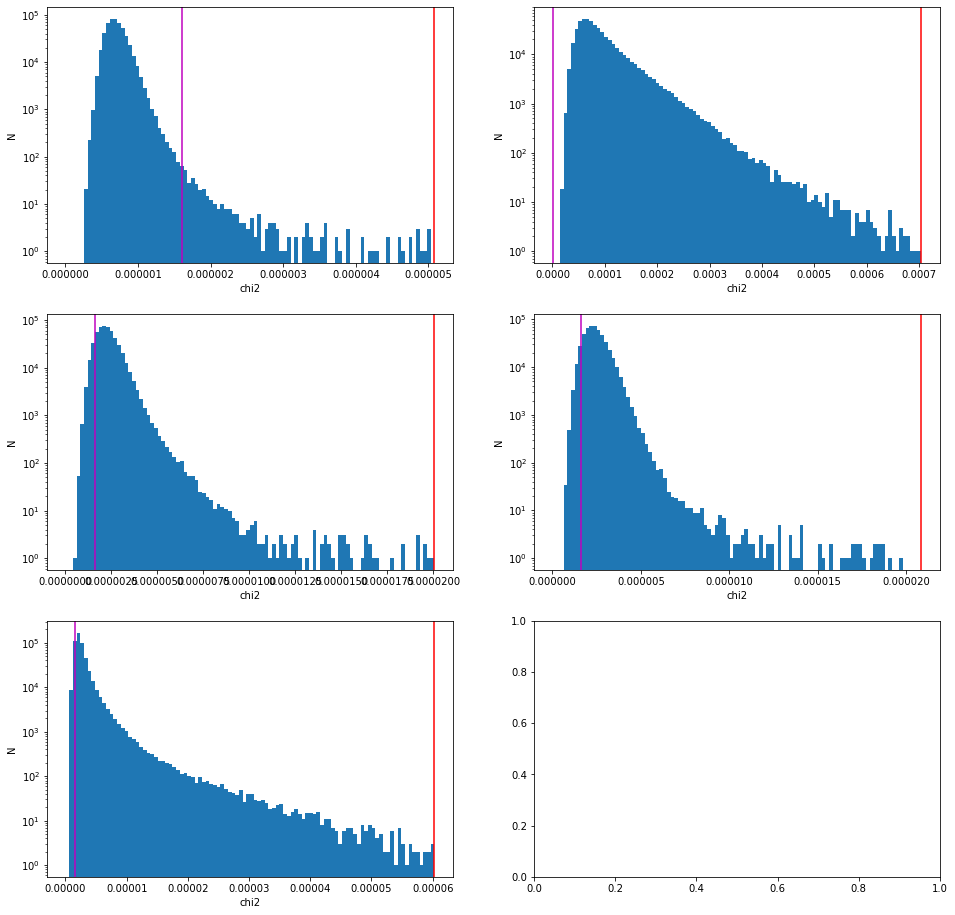

In [7]:
def get_chi2(SP_level2):
    chi2_I = SP_level2[27].data
    chi2_Q = SP_level2[28].data
    chi2_U = SP_level2[29].data
    chi2_V = SP_level2[30].data
    chi2 = SP_level2[31].data
    return chi2, chi2_I, chi2_Q, chi2_U, chi2_V

def hist_chi2(SP_level2):
    chi2, chi2_I, chi2_Q, chi2_U, chi2_V = get_chi2(SP_level2)
    fig, ((ax1, ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3, 2, figsize=(16, 16))
    hist_cut = 99.99
    thresh = 1.6e-6
    for (ax, data) in ((ax1, chi2), (ax2, chi2_I), (ax3, chi2_Q), (ax4, chi2_U), (ax5, chi2_V)):
        data1d = data.ravel()
        pct_hi = np.percentile(data1d, hist_cut)
        ax.hist(data1d, bins=100, range=(0, pct_hi))
        ax.axvline(pct_hi, c='r')
        ax.axvline(thresh, c='m')
        ax.set_yscale('log')
        ax.set_xlabel('chi2')
        ax.set_ylabel('N')
        
        sel = data1d >= thresh
        N_sel = sel.sum()
        N = data1d.size
        print(f"N_sel={N_sel} ({100*N_sel/N:0.3f}%)")

SP_level2 = astropy.io.fits.open(allfiles[80])
hist_chi2(SP_level2)

## Compute $B_{\rm LOS}$

In [332]:
def ensure_even(x):
    if x.shape[0] % 2 != 0:
        sl0 = slice(0, -1)
    else:
        sl0 = slice(x.shape[0])
    if x.shape[1] % 2 != 0:
        sl1 = slice(0, -1)
    else:
        sl1 = slice(x.shape[1])
    return x[sl0,sl1]

def degrade(x):
    x = ensure_even(x)
    return (x[0::2, 0::2] + x[1::2, 1::2])/2

def calc_Blos(SP_level2, mult_alpha=True, noise_thresh=NOISE_THRESH, degrade_normal=False):
    """Calculate the line of sight B and transverse"""
    B = np.ma.masked_array(SP_level2[1].data)
    if noise_thresh > 0 and noise_thresh < 1:
        # threshold by a percentage beyond the mode
        B_mode = modepeak(B)
        noise_thresh = B_mode * (1 + noise_thresh)

    B.mask = B <= noise_thresh
    Binc = SP_level2[2].data
    if mult_alpha:
        alpha = SP_level2[12].data
    else:
        alpha = 1
    # Take care to ensure floating point arithmetic doesn't result in negative value for sin(pi)
    sel180 = Binc == 180.
    sinBinc = np.sin(Binc * np.pi / 180.)
    cosBinc = np.cos(Binc * np.pi / 180.)
    sinBinc[sel180] = 0.
    cosBinc[sel180] = -1.
    Blos = alpha * B * cosBinc
    Bperp = np.sqrt(alpha) * B * sinBinc
    
    if degrade_normal and not is_fast(SP_level2):
        Blos = degrade(Blos)
        Bperp = degrade(Bperp)
    return Blos, Bperp

#SP_level2 = astropy.io.fits.open(example_file)
SP_level2 = astropy.io.fits.open(allfiles[1])
Blos, Bperp = calc_Blos(SP_level2, degrade_normal=True)
print("Negative Bperp:", (Bperp < 0).sum())
print(f"Masked: {Blos.mask.sum()} of {Blos.size} ({Blos.mask.sum()/Blos.size * 100:0.2f}%)")

Negative Bperp: 0
Masked: 234629 of 258304 (90.83%)


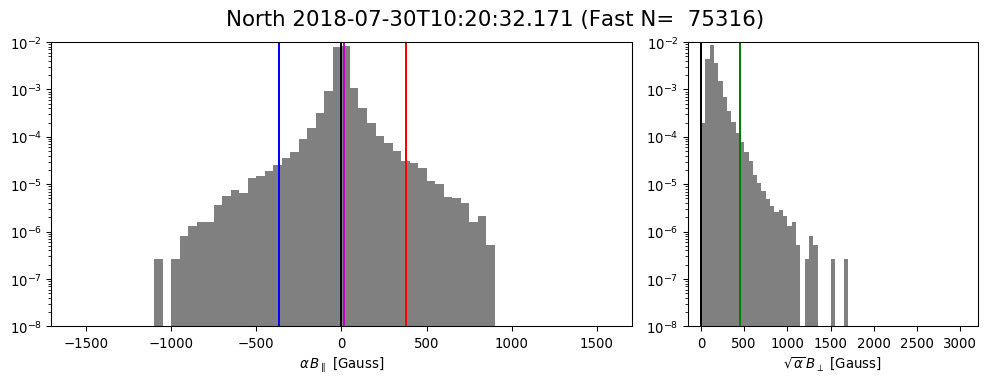

In [296]:
def plot_histogram(SP_level2, title=None, los_extent=1500, perp_extent=3000, binsize=50, 
                   save=False, show=True, dpi=96):
    if is_fast(SP_level2):
        maptype = 'Fast'
    else:
        maptype = 'Norm'
    Blos, Bperp = calc_Blos(SP_level2)
    timestamp = SP_level2[0].header['TSTART'] # TODO: get_header() function
    ok = np.logical_not(Blos.mask)
    Blos = Blos[ok]
    Bperp = Bperp[ok]
    N = ok.sum()
    pos = Blos > 0
    neg = Blos < 0
    eps = 1
    hi_Blos_pos = np.percentile(Blos[pos], 100 - eps)
    hi_Blos_neg = np.percentile(Blos[neg], eps)
    diff_Blos = hi_Blos_pos + hi_Blos_neg
    hi_Bperp = np.percentile(Bperp, 100 - eps)
    
    los_bins = np.arange(-los_extent - binsize, +los_extent + 2*binsize, binsize)
    perp_bins = np.arange(0, perp_extent + 2*binsize, binsize)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1000/dpi, 400/dpi), dpi=dpi,
                                   gridspec_kw=dict(width_ratios=[2,1]))
    N2, bins, patches = ax1.hist(np.clip(Blos.ravel(), los_bins[0], los_bins[-1]), bins=los_bins,
                                density=True, color='gray')
    patches[0].set_facecolor('r')
    patches[-1].set_facecolor('r')
    ax1.axvline(hi_Blos_pos, c='r')
    ax1.axvline(hi_Blos_neg, c='b')
    ax1.axvline(diff_Blos, c='m')
    ax1.axvline(0, c='k')
    ax1.set_xlabel(r'$\alpha \, B_\parallel$ [Gauss]')
    ax1.set_yscale('log')
    ax1.set_ylim(1e-8, 1e-2)
    N2, bins, patches = ax2.hist(np.clip(Bperp.ravel(), perp_bins[0], perp_bins[-1]), bins=perp_bins,
                                density=True, color='gray')
    patches[-1].set_facecolor('r')
    ax2.axvline(hi_Bperp, c='g')
    ax2.axvline(0, c='k')
    ax2.set_xlabel(r'$\sqrt{\alpha} \, B_\perp$ [Gauss]')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-8, 1e-2)
    title_str = f'{timestamp} ({maptype} N={N:7d})'
    if title is not None:
        title_str = title + ' ' + title_str
    fig.suptitle(title_str, y=0.98, size=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # rect to make room for suptitle
    if save:
        if save.endswith('.fits'):
            save = save[:-5]
        fig.savefig(save+'_hist.png', dpi=dpi)
    if not show:
        plt.close(fig)

plot_histogram(SP_level2, save='/Users/egeland/Desktop/test', title="North")

In [297]:
chi_thresh = 1.6e-6
binsize = 10 # Gauss
extent = 1500 # Gauss
bins = np.arange(0, +extent + 2*binsize, binsize)
normal_hist = np.zeros( bins.size - 1)
fast_hist = np.zeros( bins.size - 1)
N_normal = N_fast = 0
Npx_normal = Npx_fast = 0

for filepath in allfiles:
    file = os.path.basename(filepath)
    print(file, end=' ')
    SP_level2 = astropy.io.fits.open(filepath)
    timestamp = SP_level2[0].header['TSTART']
    plot_histogram(SP_level2, title="North", save=file, show=False)
    
    B, Binc, Bazi = get_B(SP_level2)
    chi2, chi2_I, chi2_Q, chi2_U, chi2_V = get_chi2(SP_level2)
    #B[chi2 > chi_thresh] = -1
    
    hist_i, bin_edges = np.histogram(B, bins)
    
    if is_fast(SP_level2):
        fast_hist += hist_i
        Npx_fast += B.size
        N_fast += 1
    else:
        normal_hist += hist_i
        Npx_normal += B.size
        N_normal += 1
print("Done.")

20170307_105707.fits 20170307_135606.fits 20170313_043200.fits 20170313_092904.fits 20170319_230505.fits 20170320_023405.fits 20170327_100506.fits 20170327_133406.fits 20170402_210600.fits 20170403_003405.fits 20170410_163904.fits 20170410_200101.fits 20170417_120452.fits 20170417_153704.fits 20170424_093601.fits 20170424_130405.fits 20170430_200602.fits 20170430_233405.fits 20170508_195631.fits 20170508_231104.fits 20170515_204558.fits 20170515_235633.fits 20170521_124425.fits 20170521_161106.fits 20170529_190732.fits 20170529_222204.fits 20170606_221505.fits 20170612_024748.fits 20170619_214654.fits 20170626_223342.fits 20170703_214558.fits 20170710_074204.fits 20170717_115823.fits 20170724_142534.fits 20170731_184019.fits 20170807_025149.fits 20170814_233803.fits 20170822_233505.fits 20170828_102201.fits 20170918_220808.fits 20170924_160602.fits 20171002_144442.fits 20171016_100538.fits 20171023_223505.fits 20171030_223506.fits 20171106_223600.fits 20171113_220000.fits 20171114_0102

Normalizations (normal): 21839795.0 107831808
Normalizations (fast): 3954472.0 22620160
PDF integral: 1.000000 1.000000


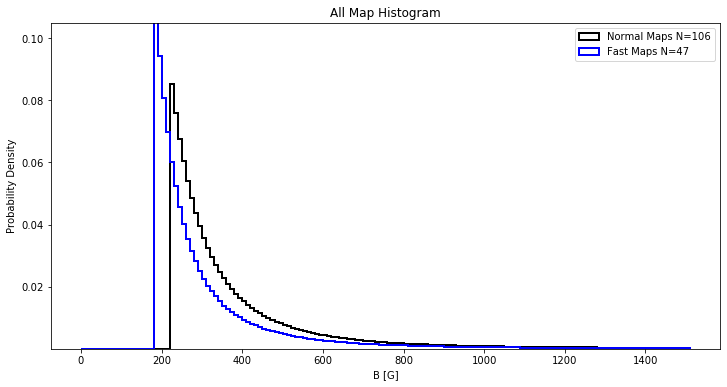

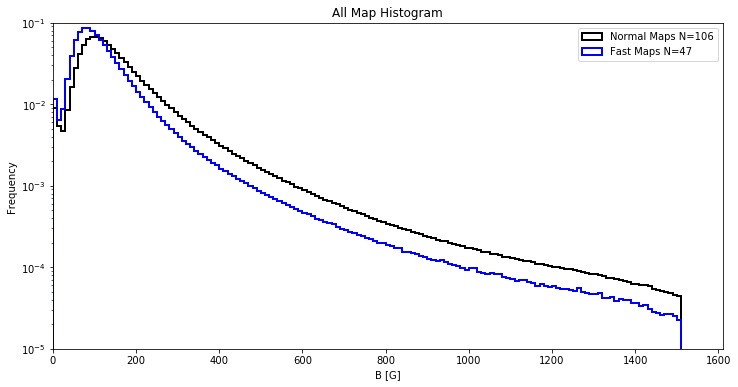

In [504]:
thresh = NOISE_THRESH
sel_normal = bins[:-1] >= NOISE_THRESH_NORMAL
sel_fast = bins[:-1] >= NOISE_THRESH_FAST
density_normal = normal_hist[sel_normal] / normal_hist[sel_normal].sum()
density_fast = fast_hist[sel_fast] / fast_hist[sel_fast].sum()

# Drawing a histogram of data that is already binned by using weights parameter
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(bins[:-1][sel_normal], bins, weights=density_normal,
        histtype='step', color='k', lw=2, label=f'Normal Maps N={N_normal}');
ax.hist(bins[:-1][sel_fast], bins, weights=density_fast,
        histtype='step', color='b', lw=2, label=f'Fast Maps N={N_fast}');
#ax.set_xlim(bins[0], bins[-1] + 100); ax.set_yscale('log')
#ax.set_xlim(50, 150)
ax.set_ylim(1e-5, 0.105)
ax.set_ylabel("Probability Density")
ax.set_xlabel("B [G]")
ax.set_title("All Map Histogram")
ax.legend()
fig.savefig('all_hist_dens.pdf', bbox_inches='tight')

frac_normal = normal_hist / Npx_normal
frac_fast = fast_hist / Npx_fast

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(bins[:-1], bins, weights=frac_normal,
        histtype='step', color='k', lw=2, label=f'Normal Maps N={N_normal}');
ax.hist(bins[:-1], bins, weights=frac_fast,
        histtype='step', color='b', lw=2, label=f'Fast Maps N={N_fast}');
ax.set_xlim(bins[0], bins[-1] + 100); ax.set_yscale('log')
#ax.set_xlim(50, 150)
ax.set_ylim(1e-5, 1e-1)
ax.set_ylabel("Frequency")
ax.set_xlabel("B [G]")
ax.set_title("All Map Histogram")
ax.legend()
fig.savefig('all_hist_freq.pdf', bbox_inches='tight')

print("Normalizations (normal):", normal_hist[sel_normal].sum(), Npx_normal)
print("Normalizations (fast):", fast_hist[sel_fast].sum(), Npx_fast)
print(f"PDF integral: {density_normal.sum():0.6f} {density_fast.sum():0.6f}")

## Notes

 * Why is there a lower probability to find a given field strength in a fast map than a normal map?
   * Nevermind!  The above was a misconception when I made PDFs with different ranges
 * Why is there a lower frequency of a given field strength in a fast map than a normal map?
   * **The frequency is about a factor of 2 lower (WHY?).**  The number of pixels is about a factor of 2 smaller.  Resolution is a factor of 4 lower.  FoV is factor of 2 larger.

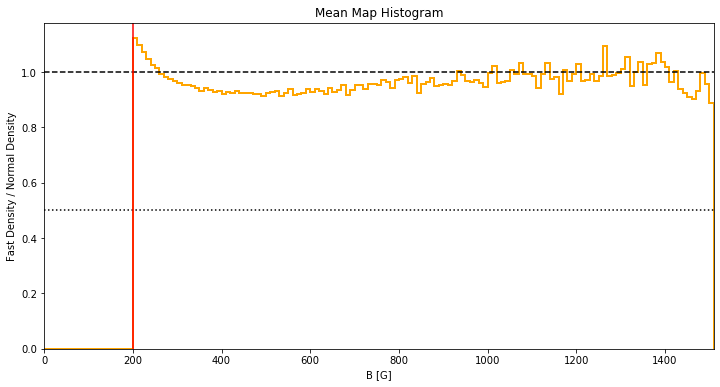

In [290]:
# TODO: update to reflect selections above

hist_ratio = np.divide(density_fast, density_normal); x_bins = bins[:-1][sel_fast]
#hist_ratio = np.divide(fast_hist/fast_hist.sum(), normal_hist/normal_hist.sum()); x_bins = bins[:-1]
#hist_ratio = np.divide(frac_fast, frac_normal); x_bins = bins[:-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(x_bins, bins, weights=hist_ratio, histtype='step', color='orange', lw=2, label=f'Normal - Fast');
ax.axhline(1.0, color='k', ls='--')
ax.axhline(0.5, color='k', ls=':')
ax.axvline(thresh, color='r')
ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel("Fast Density / Normal Density")
ax.set_xlabel("B [G]")
ax.set_title("Mean Map Histogram")
fig.savefig('all_hist_density_ratio.pdf', bbox_inches='tight')

## Radial Approximation

In [125]:
def hproj2hgraph(x, y, t):
    hproj = astropy.coordinates.SkyCoord(x*u.arcsec, y*u.arcsec, 
                                     frame=sunpy.coordinates.frames.Helioprojective,
                                     observer='earth', obstime=t)
    hgraph = hproj.transform_to(sunpy.coordinates.frames.HeliographicCarrington)
    lon = hgraph.lon.deg
    lat = hgraph.lat.deg
    return lon, lat

In [352]:
def calc_Br(SP_level2, mult_alpha=True, noise_thresh=NOISE_THRESH, plane=False, degrade_normal=False):
    Blos, Bperp = calc_Blos(SP_level2, mult_alpha=mult_alpha, noise_thresh=noise_thresh, degrade_normal=degrade_normal)
    if plane:
        x = SP_level2[0].header['XCEN'] # arcsec
        y = SP_level2[0].header['YCEN'] # arcsec
    else:
        x = SP_level2[38].data # arcsec
        y = SP_level2[39].data # arcsec
        if degrade_normal and not is_fast(SP_level2):
            # Average adjacent pixels in X and Y
            x = degrade(x)
            y = degrade(y)
    timestamp = SP_level2[0].header['TSTART'] # TODO: get_header() function
    lon, lat = hproj2hgraph(x, y, timestamp) # degrees
    B0 = sunpy.coordinates.sun.B0(timestamp).deg # degrees
    LOS_angle = (lat - B0) * (np.pi/180.) # radians; angle from LOS to radial vector
    Br = Blos / np.cos(LOS_angle)
    return Br
    
SP_level2 = astropy.io.fits.open(example_file)
Br = calc_Br(SP_level2)

## Gather Statistics

In [464]:
ts = {}
stat_keys = ('t', 'xcen', 'ycen', 'latcen', 'loncen',
             'p_angle', 'b_angle', 'xscale', 'yscale',
             'ytop', 'ybot', 'lattop', 'latbot',
             'B_mode', 
             'Blos_sum', 'absBlos_sum', 'Blos_mean', 'absBlos_mean', 'ulosflux',
             'Br_sum', 'absBr_sum', 'Br_mean', 'absBr_mean', 'urflux',
             'N', 'Nx', 'Ny', 'Nok', 'area_i', 'area', 'area_ok', 'fastmap')
for k in stat_keys:
    ts[k] = []
    
DEGRADE = True
    
for filepath in allfiles:
    print(os.path.basename(filepath), end=' ')
    SP_level2 = astropy.io.fits.open(filepath)
    timestamp = SP_level2[0].header['TSTART']    
    x = SP_level2[0].header['XCEN']
    y = SP_level2[0].header['YCEN']
    p_angle = SP_level2[0].header['p_angle']
    b_angle = SP_level2[0].header['b_angle']
    xscale = SP_level2[0].header['XSCALE']
    yscale = SP_level2[0].header['YSCALE']
    lon, lat = hproj2hgraph(x, y, timestamp)
    fastmap = is_fast(SP_level2)
    ts['t'].append(timestamp)
    ts['xcen'].append(x)
    ts['ycen'].append(y)
    ts['latcen'].append(lat)
    ts['loncen'].append(lon)
    ts['p_angle'].append(p_angle)
    ts['b_angle'].append(b_angle)
    ts['fastmap'].append(fastmap)
    B, Binc, Bazi = get_B(SP_level2)
    B_mode = modepeak(B)
    ts['B_mode'].append(B_mode)
    if fastmap:
        thresh = NOISE_THRESH_FAST
    else:
        thresh = NOISE_THRESH_NORMAL
    thresh = NOISE_THRESH # uncomment to use global nose thresh
    Blos, Bperp = calc_Blos(SP_level2, noise_thresh=thresh, degrade_normal=DEGRADE)
    Br = calc_Br(SP_level2, noise_thresh=thresh, degrade_normal=DEGRADE)
    ok = np.logical_not(Blos.mask)
    Nok = ok.sum()
    # Nok = N # XXX without correction
    ts['Nok'].append(Nok)
    
    Ny, Nx = Blos.shape
    N = Blos.size
    if DEGRADE and not fastmap:
        xscale = xscale*2
        yscale = yscale*2
        
    ts['N'].append(N)
    ts['Nx'].append(Nx)
    ts['Ny'].append(Ny)
    ts['xscale'].append(xscale)
    ts['yscale'].append(yscale)
    
    ytop = y + (Ny * yscale)/2
    ybot = y - (Ny * yscale)/2
    zerolon, lattop = hproj2hgraph(0, ytop, timestamp)
    zerolon, latbot = hproj2hgraph(0, ybot, timestamp)
    ts['ytop'].append(ytop)
    ts['ybot'].append(ybot)
    ts['lattop'].append(lattop)
    ts['latbot'].append(latbot)
    
    # Areas
    area_i = xscale * yscale
    area = N * area_i
    area_ok = Nok * area_i
    ts['area'].append(area)
    ts['area_i'].append(area_i)
    ts['area_ok'].append(area_ok)
    
    # LOS-based quantities
    Blos = Blos[ok]
    Bperp = Bperp[ok]
    absBlos = np.abs(Blos)
    Blos_sum = Blos.sum()
    absBlos_sum = absBlos.sum()
    Blos_mean = Blos.mean()
    absBlos_mean = absBlos.mean()
    ulosflux = area_ok * absBlos_sum
    ts['Blos_sum'].append(Blos_sum)
    ts['absBlos_sum'].append(absBlos_sum)
    ts['Blos_mean'].append(Blos_mean)
    ts['absBlos_mean'].append(absBlos_mean)
    ts['ulosflux'].append(ulosflux)
    
    # radial-based quantities
    Br = Br[ok]
    absBr = np.abs(Br)
    Br_sum = Br.sum()
    absBr_sum = absBr.sum()
    Br_mean = Br.mean()
    absBr_mean = absBr.mean()
    urflux = area_ok * absBr_sum
    ts['Br_sum'].append(Br_sum)
    ts['absBr_sum'].append(absBr_sum)
    ts['Br_mean'].append(Br_mean)
    ts['absBr_mean'].append(absBr_mean)
    ts['urflux'].append(urflux)
    
    SP_level2.close()
print("Done.")

ts['t'] = astropy.time.Time(ts['t'])
for k in stat_keys[1:]:
    ts[k] = np.array(ts[k])

20170307_105707.fits 20170307_135606.fits 20170313_043200.fits 20170313_092904.fits 20170319_230505.fits 20170320_023405.fits 20170327_100506.fits 20170327_133406.fits 20170402_210600.fits 20170403_003405.fits 20170410_163904.fits 20170410_200101.fits 20170417_120452.fits 20170417_153704.fits 20170424_093601.fits 20170424_130405.fits 20170430_200602.fits 20170430_233405.fits 20170508_195631.fits 20170508_231104.fits 20170515_204558.fits 20170515_235633.fits 20170521_124425.fits 20170521_161106.fits 20170529_190732.fits 20170529_222204.fits 20170606_221505.fits 20170612_024748.fits 20170619_214654.fits 20170626_223342.fits 20170703_214558.fits 20170710_074204.fits 20170717_115823.fits 20170724_142534.fits 20170731_184019.fits 20170807_025149.fits 20170814_233803.fits 20170822_233505.fits 20170828_102201.fits 20170918_220808.fits 20170924_160602.fits 20171002_144442.fits 20171016_100538.fits 20171023_223505.fits 20171030_223506.fits 20171106_223600.fits 20171113_220000.fits 20171114_0102

# Pointings

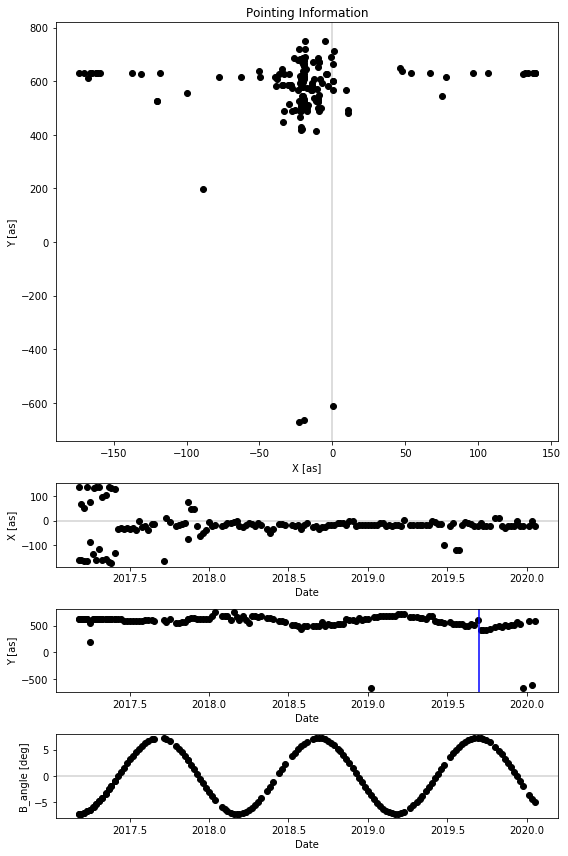

In [465]:
def plot_pointings(sel=None, Y='ycen'):
    if sel is None:
        sel = np.ones_like(ts['xcen'], dtype='bool')
    if Y == 'ycen':
        Ylabel = 'Y [as]'
    elif Y == 'latcen':
        Ylabel = 'Lat [deg]'
    else:
        raise Exception("Y must be ycen or latcen")
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8,12), gridspec_kw={'height_ratios': [5,1,1,1]})
    ax1.set_title("Pointing Information")
    ax1.plot(ts['xcen'][sel], ts[Y][sel], 'ko')
    ax1.axvline(0, c='lightgray', zorder=-1)
    ax1.set_xlabel("X [as]")
    ax1.set_ylabel(Ylabel)
    ax2.plot(ts['t'][sel].decimalyear, ts['xcen'][sel], 'ko')
    ax2.axhline(0, c='lightgray', zorder=-1)
    ax2.set_ylabel("X [as]")
    ax2.set_xlabel("Date")
    ax3.plot(ts['t'][sel].decimalyear, ts[Y][sel], 'ko')
    repoint = 2019.70
    if ts['t'][sel].decimalyear[-1] > repoint:
        ax3.axvline(repoint, c='b')
    ax3.set_ylabel(Ylabel)
    ax3.set_xlabel("Date")
    ax4.plot(ts['t'][sel].decimalyear, ts['b_angle'][sel], 'ko')
    ax4.axhline(0, c='lightgray', zorder=-1)
    ax4.set_ylabel("B_angle [deg]")
    ax4.set_xlabel("Date")
    fig.tight_layout()
    
plot_pointings()

In [466]:
# Filter out observations with Y < 400
bad = ts['ycen'] < 400
ok = np.logical_not(bad)
print("{} out of {} Y pointings are OK".format(ok.sum(), ok.size))
print("bad ycen:", "t=", ts['t'][bad], "ycen=", ts['ycen'][bad], "xcen=", ts['xcen'][bad])
print("bad ixs:", np.where(bad))

149 out of 153 Y pointings are OK
bad ycen: t= ['2017-04-02T21:06:00.951' '2019-01-07T03:04:05.159'
 '2019-12-23T09:18:07.062' '2020-01-13T14:04:04.823'] ycen= [ 198.642 -664.135 -672.017 -611.822] xcen= [-88.7532   -19.658    -22.9365     0.233292]
bad ixs: (array([  8, 102, 149, 151]),)


### Result

 * 2017-04-02T21:06:00.951 ycen=198.642: Hinode pointing was -176.9/  622.0 in re-point file; ycen in header is wrong
   * Solution: update ycen with value from paired pointing after 2017/04/03 00:30:00 (next obs)
 * 2019-01-07T03:04:05.159 ycen=-664.135: Level-2 data was not found.  Script gathered result from next pointing, which was in the south.
   * Solution: remove observation from north set (TODO: fix classifcation from find336data.pl)
 * 2019-12-23T09:18:07.062 ycen=-672.017: Script gathered result from next pointing, which was HOP 336 south
   * Solution: remove observation from north set (TODO: fix classifcation from find336data.pl)
 * 2020-01-13T14:04:04.823 ycen=-611.822: Script gathered result from next pointing, which was HOP 336 south
   * Solution: remove observation from north set (TODO: fix classifcation from find336data.pl)

In [467]:
# Uupdate ycen of observation at 2017-04-02T21:06:00.951
print(ts['t'][8], ts['t'][9])
print(ts['ycen'][8], '=>', ts['ycen'][9])
ts['ycen'][8] = ts['ycen'][9]
print(ts['ycen'][8], '==', ts['ycen'][9])
bad[8] = False

2017-04-02T21:06:00.951 2017-04-03T00:34:05.213
198.642 => 544.057
544.057 == 544.057


In [468]:
# Remove southern observations
if ts['ycen'][102] < 0:
    ok = np.logical_not(bad)
    print("Removing southern observation at index", np.where(bad))
    for k in ts.keys():
        ts[k] = ts[k][ok]
else:
    print("bad ycen already removed")

Removing southern observation at index (array([102, 149, 151]),)


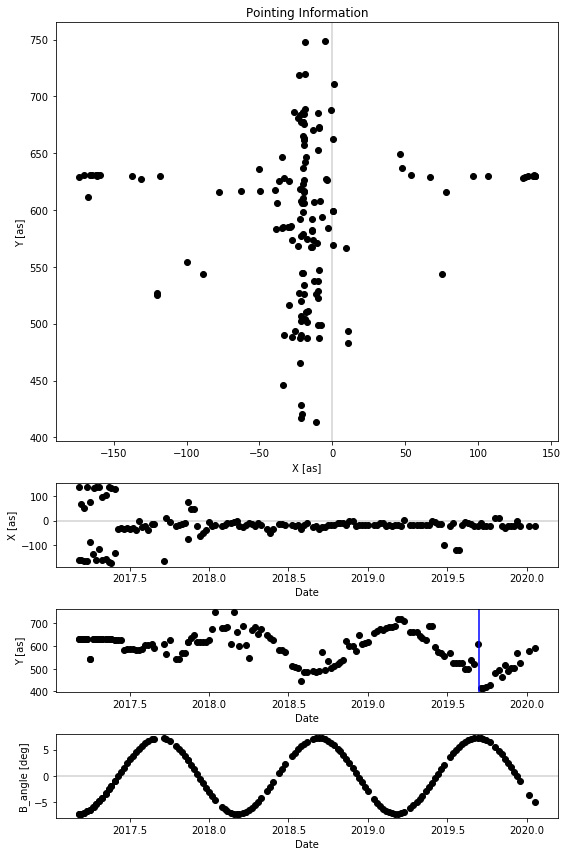

In [469]:
plot_pointings()

In [470]:
# Check out anomalous pointing in early observations
print("early ycens:", ts['ycen'][0:10])
suspicious = np.where((ts['t'].decimalyear < 2017.5) & (ts['ycen'] < 550))
print("suspicious:", suspicious)
print("suspictious t:", ts['t'][suspicious])

early ycens: [630.442 629.966 630.137 629.307 630.531 630.426 630.603 630.163 544.057
 544.057]
suspicious: (array([8, 9]),)
suspictious t: ['2017-04-02T21:06:00.951' '2017-04-03T00:34:05.213']


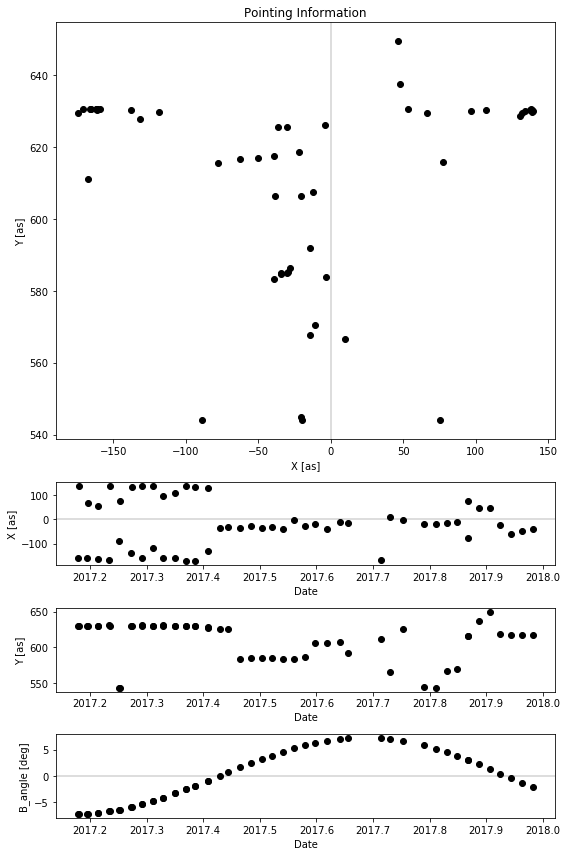

In [471]:
# Zoom on early observations to see the X positions better
plot_pointings(ts['t'].decimalyear < 2018.0)
#plot_pointings((ts['t'].decimalyear > 2019.4) & (ts['t'].decimalyear < 2020.0))

In [472]:
# connect paired observations into single image
# NOTE: or just analyze them independently and average the results?
print("time:", ts['t'][0], ts['t'][1])
print("xcen:", ts['xcen'][0], ts['xcen'][1])
print("Nx:", ts['Nx'][0], ts['Nx'][1])
print("xscale:", ts['xscale'][0], ts['xscale'][1])
print("width:", ts['xscale'][0] * ts['Nx'][0], ts['xscale'][1] *  ts['Nx'][1])
print("Delta xcen:", ts['xcen'][1] - ts['xcen'][0])
print('Edges:', ts['xcen'][0] + ts['xscale'][0] * ts['Nx'][0] / 2, ts['xcen'][1] - ts['xscale'][1] *  ts['Nx'][1]/2)

# TODO finish

time: 2017-03-07T10:57:07.561 2017-03-07T13:56:06.222
xcen: -161.098 139.124
Nx: 1017 1009
xscale: 0.29714 0.29714
width: 302.19138000000004 299.81426
Delta xcen: 300.222
Edges: -10.002309999999994 -10.78313


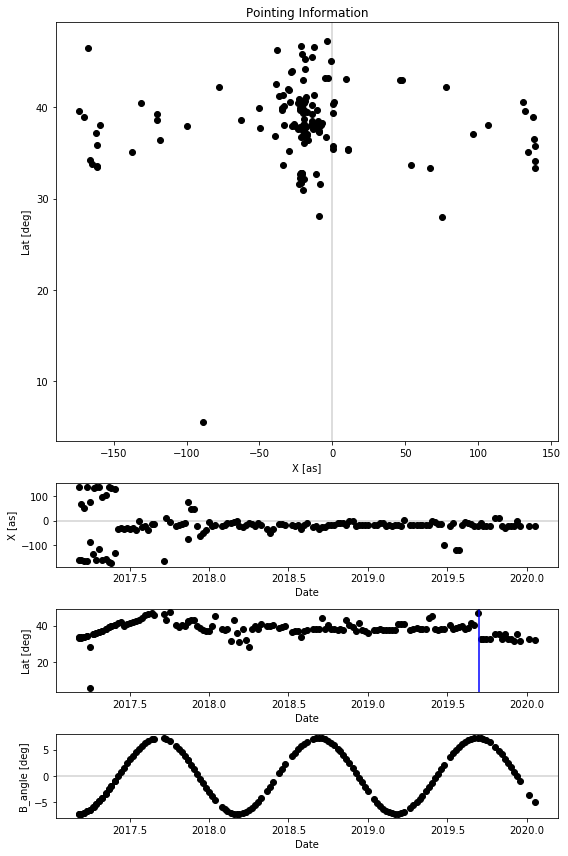

In [473]:
plot_pointings(Y='latcen')

In [474]:
fast = ts['fastmap']
normal = np.logical_not(fast) # normal map selection

Average band launch: 10.650 yr


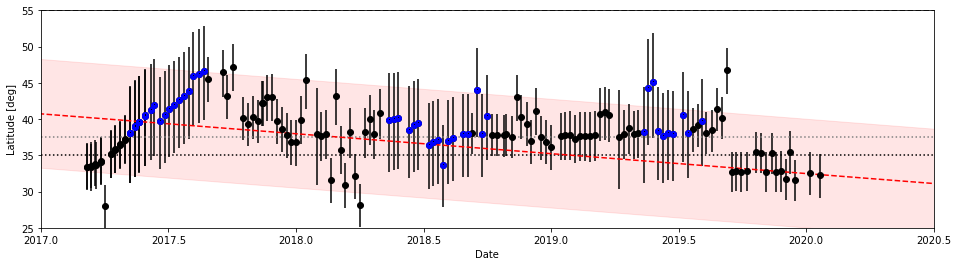

In [475]:
north_bands = np.array([1884.0, 1892.50, 1905.75, 1917.58, 1925.92, 1937.50, 
                        1949.17, 1959.08, 1968.00, 1979.67, 1989.08, 2000.50, 2011.80])
avg_Dband = (north_bands[1:] - north_bands[0:-1]).mean()
avg_Dterm = 10.85 # yr; McIntosh 2019 SoPh
print(f"Average band launch: {avg_Dband:0.3f} yr")
t_band25 = np.array([2011.80, 2031.83]) # Leamon et al. 2020
lat_range = np.array([55.0, 0.0])
band_halfwidth = 7.5 # deg
fig, ax = plt.subplots(figsize=(16,4))
ax.axhline(55, c='k', ls='--')
ax.axhline(37.5, c='gray', ls=':')
ax.axhline(35, c='k', ls=':')
ax.axhline(0, c='k', ls='-')
ax.plot(t_band25, lat_range, 'r--')
ax.fill_between(t_band25, lat_range + band_halfwidth, lat_range - band_halfwidth, color='r', alpha=0.1)
ax.plot(ts['t'].decimalyear, ts['latcen'], 'ko')
ax.plot(ts['t'][fast].decimalyear, ts['latcen'][fast], 'bo')
yerr = np.array([ts['lattop']-ts['latcen'],ts['latcen']-ts['latbot']])
ax.errorbar(ts['t'].decimalyear, ts['latcen'], yerr=yerr, fmt=',', c='k')

ax.set_xlim(2017,2020.5)
ax.set_ylim(25, 55)

ax.set_xlabel("Date")
ax.set_ylabel("Latitude [deg]")
fig.savefig('N_pointings.pdf', bbox_inches='tight')

## Generate Plots

figsize=(11.17, 12.74)


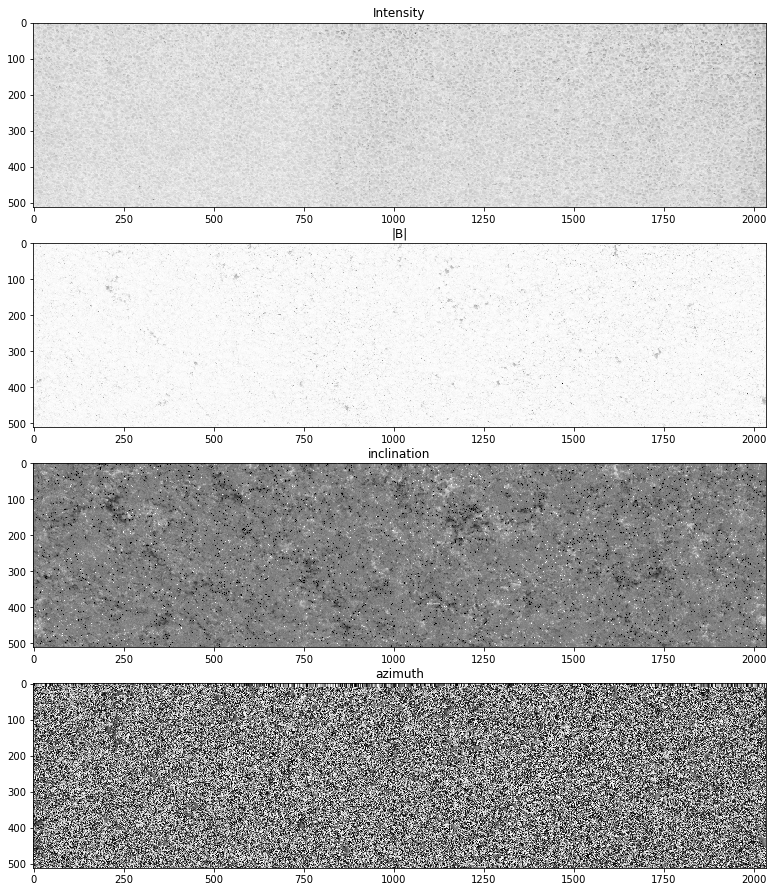

In [476]:
# TODO: plot masked pixels with different color
def plot_Bcomponents(SP_level2, dpi=mpl.rcParams['figure.dpi'], margin=0.5):
    B, Binc, Bazi = get_B(SP_level2)
    I = SP_level2[32].data # TODO: write get_I()
    
    height, width = B.shape # pixels
    panelsize = width / dpi, height / dpi # inches
    figsize = panelsize[0] + 2*margin, margin + 4 * (panelsize[1] + margin)
    print(f'figsize={figsize}')
    panel_w = panelsize[0]/figsize[0] # fraction
    panel_h = panelsize[1]/figsize[1] # fraction
    margin_w = margin / figsize[0]
    margin_h = margin / figsize[1]
    x1 = margin_w
    y1 = 1 - panel_h - margin_h
        
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_axes([x1, y1, panel_w, panel_h])
    ax1.imshow(I, cmap='gray_r')
    ax1.set_title("Intensity")
    y1 -= (margin_h + panel_h)
    ax2 = fig.add_axes([x1, y1, panel_w, panel_h])
    ax2.imshow(B, cmap='gray_r')
    ax2.set_title("|B|")
    y1 -= (margin_h + panel_h)
    ax3 = fig.add_axes([x1, y1, panel_w, panel_h])
    ax3.imshow(Binc, cmap='gray_r')
    ax3.set_title("inclination")
    y1 -= (margin_h + panel_h)
    ax4 = fig.add_axes([x1, y1, panel_w, panel_h])
    ax4.imshow(Bazi, cmap='gray_r')
    ax4.set_title('azimuth')
    
SP_level2 = astropy.io.fits.open(example_file)
plot_Bcomponents(SP_level2, dpi=200)
SP_level2.close()

2017-03-07T10:57:07.561: (2034, 512) => (302.19138000000004, 81.915904)


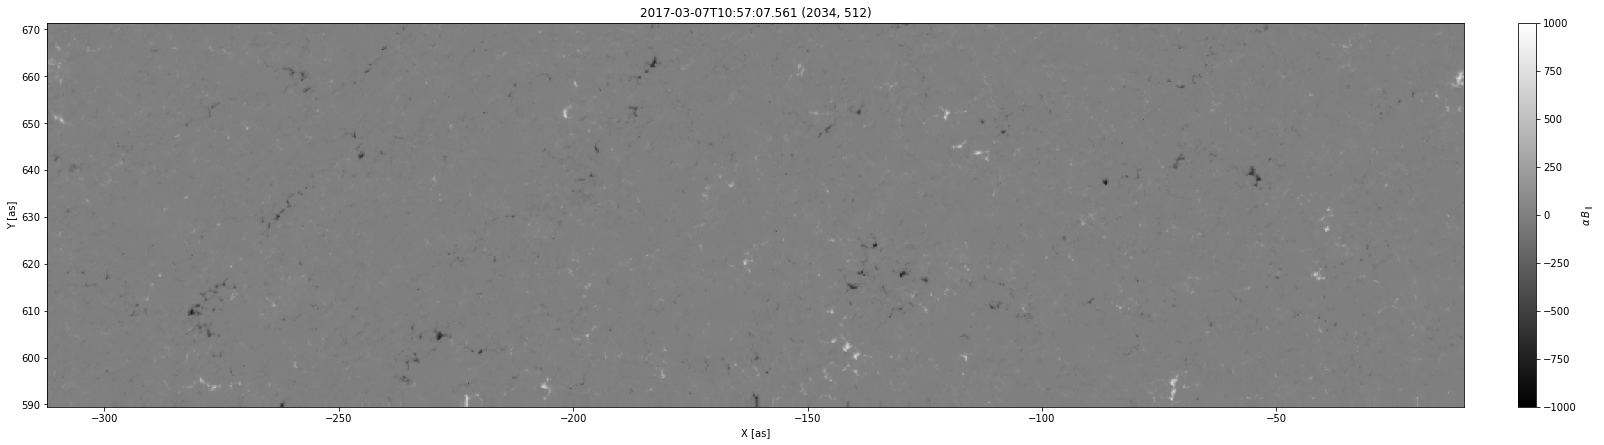

In [477]:
# TODO: plot masked components with different color
def plot_Blos(SP_level2, margin=0.5, Bscale=None, save=False, show=True, dpi=96, ):
    Blos, Bperp = calc_Blos(SP_level2, noise_thresh=0)
    timestamp = SP_level2[0].header['TSTART'] # TODO: write get_header()
    Ny, Nx = Blos.shape
    xcen = SP_level2[0].header['XCEN']
    ycen = SP_level2[0].header['YCEN']
    xscale = SP_level2[0].header['XSCALE']
    yscale = SP_level2[0].header['YSCALE']
    
    width = xscale * Nx
    height = yscale * Ny
    extent = [xcen - width/2, xcen + width/2, ycen - height/2, ycen + height/2] # left, right, bottom, top
    print(f"{timestamp}: ({Nx}, {Ny}) => ({width}, {height})")
    
    panelsize = Nx / dpi, Ny / dpi # inches
    figsize = panelsize[0] + 2*margin, panelsize[1] + 2*margin
    panel_w = panelsize[0]/figsize[0] # fraction
    panel_h = panelsize[1]/figsize[1] # fraction
    margin_w = margin / figsize[0]
    margin_h = margin / figsize[1]
    x1 = margin_w
    y1 = 1 - panel_h - margin_h
    if Bscale is None:
        Bscale = np.max(np.abs([Blos.min(), Blos.max()]))
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_axes([x1, y1, panel_w, panel_h])
    pos = ax1.imshow(Blos, cmap='gray', vmin=-Bscale, vmax=+Bscale, origin='bottom', extent=extent)
    ax1.set_xlabel("X [as]")
    ax1.set_ylabel("Y [as]")
    ax1.set_title(f'{timestamp} ({Nx}, {Ny})')
    ax2 = fig.add_axes([x1+panel_w, y1, margin_w/2, panel_h])
    fig.colorbar(pos, cax=ax2, label=r"$\alpha \, B_\parallel$")
    if save:
        if save.endswith('.fits'):
            save = save[:-5]
        fig.savefig(save+'_Blos.png', bbox_inches='tight')
    if not show:
        plt.close(fig)

SP_level2 = astropy.io.fits.open(example_file)
plot_Blos(SP_level2, Bscale=1000, save='test')
SP_level2.close()

In [478]:
for filepath in allfiles:
    SP_level2 = astropy.io.fits.open(filepath)
    timestamp = SP_level2[0].header['TSTART']
    plot_Blos(SP_level2, Bscale=1000, save=file, show=False)
print("Done.")

2017-03-07T10:57:07.561: (2034, 512) => (302.19138000000004, 81.915904)
2017-03-07T13:56:06.222: (2019, 512) => (299.96283, 81.915904)
2017-03-13T04:32:00.725: (2030, 512) => (301.5971, 81.915904)
2017-03-13T09:29:04.466: (1764, 512) => (262.081008, 81.91488)
2017-03-19T23:05:05.875: (2020, 512) => (300.1114, 81.915904)
2017-03-20T02:34:05.152: (961, 512) => (142.774809, 81.914368)
2017-03-27T10:05:06.348: (2033, 512) => (302.04281000000003, 81.915904)
2017-03-27T13:34:06.229: (2017, 512) => (299.66569000000004, 81.915904)
2017-04-02T21:06:00.951: (2039, 512) => (302.93423, 81.915904)
2017-04-03T00:34:05.213: (1953, 512) => (290.15721, 81.915392)
2017-04-10T16:39:04.858: (2024, 512) => (300.70568000000003, 81.915904)
2017-04-10T20:01:01.324: (1957, 512) => (290.75149, 81.915392)
2017-04-17T12:04:52.149: (2027, 512) => (301.15139, 81.915904)
2017-04-17T15:37:04.128: (2012, 512) => (298.92284, 81.915904)
2017-04-24T09:36:01.036: (2033, 512) => (302.04281000000003, 81.915904)
2017-04-24T1

2019-07-08T18:54:16.770: (978, 512) => (290.601942, 163.828736)
2019-07-15T19:44:58.154: (990, 512) => (294.16760999999997, 163.828736)
2019-07-22T10:43:13.672: (511, 512) => (75.91927, 81.914368)
2019-07-29T21:20:54.254: (503, 512) => (74.73071, 81.914368)
2019-08-04T20:06:59.098: (997, 512) => (296.24758299999996, 163.828736)
2019-08-10T20:22:02.919: (1965, 512) => (291.94005000000004, 81.915392)
2019-08-19T12:06:05.034: (2010, 512) => (298.6257, 81.915904)
2019-08-26T10:06:11.955: (1986, 512) => (295.06002, 81.915904)
2019-09-02T10:06:00.877: (1970, 512) => (292.6829, 81.915392)
2019-09-09T20:35:20.744: (2021, 512) => (300.25997, 81.915904)
2019-09-16T18:18:31.225: (2018, 512) => (299.81426, 81.915904)
2019-09-22T09:06:01.339: (2030, 512) => (301.5971, 81.915904)
2019-09-29T18:04:01.752: (1979, 512) => (294.02003, 81.915904)
2019-10-07T22:05:35.660: (2025, 512) => (300.85425000000004, 81.915904)
2019-10-20T14:06:03.917: (2001, 512) => (297.28857, 81.915904)
2019-10-28T19:36:59.431: 

## Plot Time Series

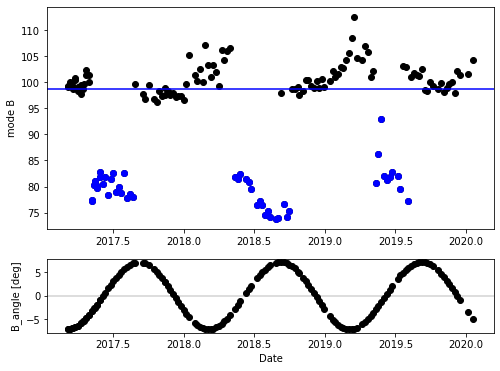

In [479]:
median_B_mode = np.median(ts['B_mode'])
fig, (ax1, ax1b) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios':(3,1)})
ax1.plot(ts['t'].decimalyear, ts['B_mode'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['B_mode'][fast], 'bo')
ax1.axhline(median_B_mode, c='b')
ax1.set_ylabel('mode B')
ax1b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax1b.axhline(0, c='lightgray', zorder=-1)
ax1b.set_ylabel("B_angle [deg]")
ax1b.set_xlabel("Date")
fig.savefig("ts_modeB.pdf", bbox_inches='tight')

### TODO B-angle, pixel scale & quiet Sun

 * More precicely find the mode of $|B|$ by fitting a quadratic to the top of the histogram
 * Check if the mode of $|B|$ follows the B-angle
   * Looks like max(B-angle) (north-pointing) results in min($|B|$)
   * Why would that be?  When B-angle is large, the pixel area represents smaller physical area (better resolution).  This results in lower mode, because the filling factor is smaller?
 * Check if the mode of $|B|$ follows the pixel scale changes
   * Mark pixel scale transitions in this and **all** time series
     * Might want to just work with the pixel scales separately until I figure out how to erase the changes

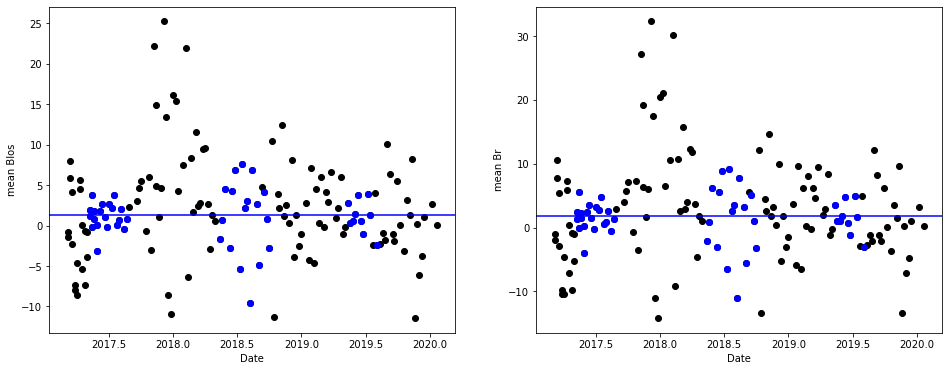

In [480]:
median_Blos_mean = np.median(ts['Blos_mean'])
median_Br_mean = np.median(ts['Br_mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(ts['t'].decimalyear, ts['Blos_mean'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['Blos_mean'][fast], 'bo')
ax1.axhline(median_Blos_mean, c='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('mean Blos')

ax2.plot(ts['t'].decimalyear, ts['Br_mean'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['Br_mean'][fast], 'bo')
ax2.axhline(median_Br_mean, c='b')
ax2.set_xlabel('Date')
ax2.set_ylabel('mean Br')
fig.savefig("ts_meanB.pdf", bbox_inches='tight')

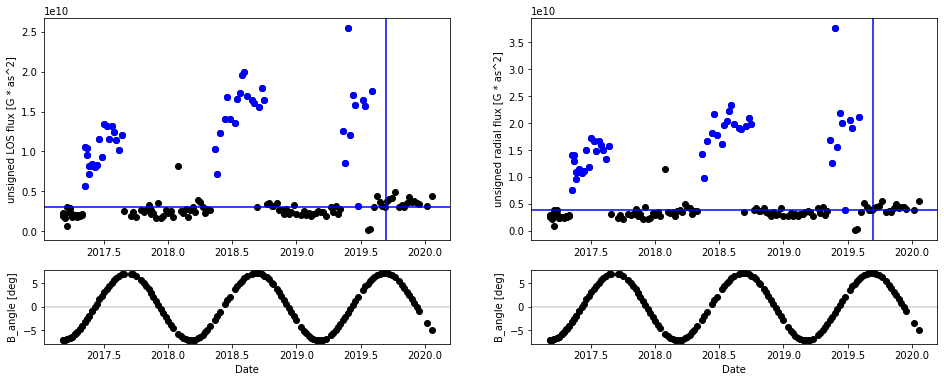

In [481]:
median_ulosflux = np.median(ts['ulosflux'])
fig, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(2, 2, figsize=(16,6), gridspec_kw={'height_ratios':(3,1)})
ax1.plot(ts['t'].decimalyear, ts['ulosflux'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['ulosflux'][fast], 'bo')
ax1.axhline(median_ulosflux, c='b')
ax1.axvline(2019.7, c='b')
ax1.set_ylabel('unsigned LOS flux [G * as^2]')
#ax1.set_ylim(0, 2.0 * median_ulosflux) # High point due to large map
ax1b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax1b.axhline(0, c='lightgray', zorder=-1)
ax1b.set_ylabel("B_angle [deg]")
ax1b.set_xlabel("Date")

median_urflux = np.median(ts['urflux'])
ax2.plot(ts['t'].decimalyear, ts['urflux'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['urflux'][fast], 'bo')
ax2.axhline(median_urflux, c='b')
ax2.axvline(2019.7, c='b')
ax2.set_ylabel('unsigned radial flux [G * as^2]')
#ax2.set_ylim(0, 2.0 * median_urflux) # High point due to large map
ax2b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax2b.axhline(0, c='lightgray', zorder=-1)
ax2b.set_ylabel("B_angle [deg]")
ax2b.set_xlabel("Date")
fig.savefig("ts_uflux.pdf", bbox_inches='tight')

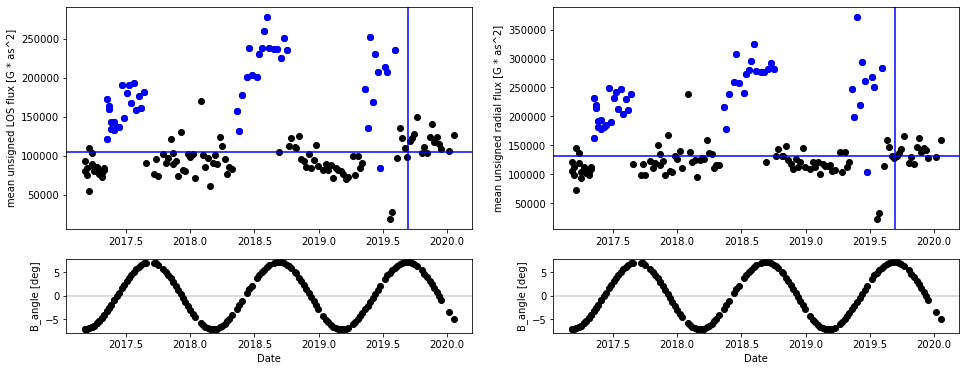

In [482]:
median_ulosflux = np.median(ts['ulosflux']/ts['Nok']) 
fig, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(2, 2, figsize=(16,6), gridspec_kw={'height_ratios':(3,1)})
ax1.plot(ts['t'].decimalyear, ts['ulosflux']/ts['Nok'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['ulosflux'][fast]/ts['Nok'][fast], 'bo')
ax1.axhline(median_ulosflux, c='b')
ax1.axvline(2019.7, c='b')
ax1.set_ylabel('mean unsigned LOS flux [G * as^2]')
ax1b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax1b.axhline(0, c='lightgray', zorder=-1)
ax1b.set_ylabel("B_angle [deg]")
ax1b.set_xlabel("Date")

median_urflux = np.median(ts['urflux']/ts['Nok'])
ax2.plot(ts['t'].decimalyear, ts['urflux']/ts['Nok'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['urflux'][fast]/ts['Nok'][fast], 'bo')
ax2.axhline(median_urflux, c='b')
ax2.axvline(2019.7, c='b')
ax2.set_ylabel('mean unsigned radial flux [G * as^2]')
ax2b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax2b.axhline(0, c='lightgray', zorder=-1)
ax2b.set_ylabel("B_angle [deg]")
ax2b.set_xlabel("Date")
fig.savefig("ts_uflux_mean.pdf", bbox_inches='tight')

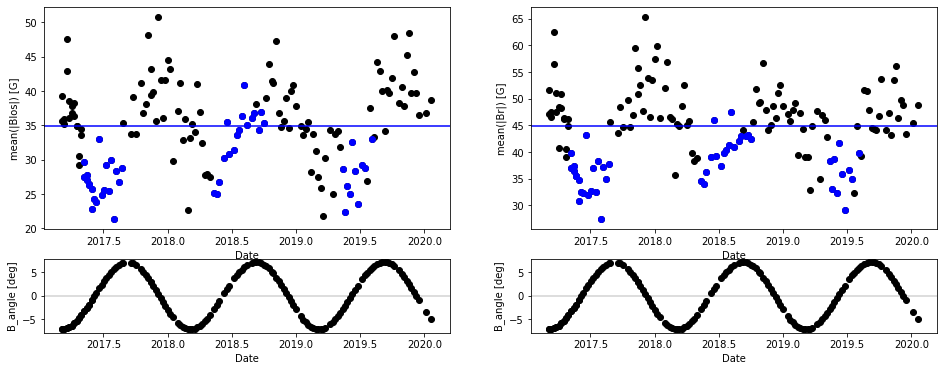

In [483]:
median_absBlos_mean = np.median(ts['absBlos_mean'])
fig, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(2, 2, figsize=(16,6), gridspec_kw={'height_ratios':(3,1)})
ax1.plot(ts['t'].decimalyear, ts['absBlos_mean'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['absBlos_mean'][fast], 'bo')
ax1.axhline(median_absBlos_mean, c='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('mean(|Blos|) [G]')
ax1b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax1b.axhline(0, c='lightgray', zorder=-1)
ax1b.set_ylabel("B_angle [deg]")
ax1b.set_xlabel("Date")

median_absBr_mean = np.median(ts['absBr_mean'])
ax2.plot(ts['t'].decimalyear, ts['absBr_mean'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['absBr_mean'][fast], 'bo')
ax2.axhline(median_absBr_mean, c='b')
ax2.set_xlabel('Date')
ax2.set_ylabel('mean(|Br|) [G]')
ax2b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax2b.axhline(0, c='lightgray', zorder=-1)
ax2b.set_ylabel("B_angle [deg]")
ax2b.set_xlabel("Date")
fig.savefig("ts_meanabsB.pdf", bbox_inches='tight')

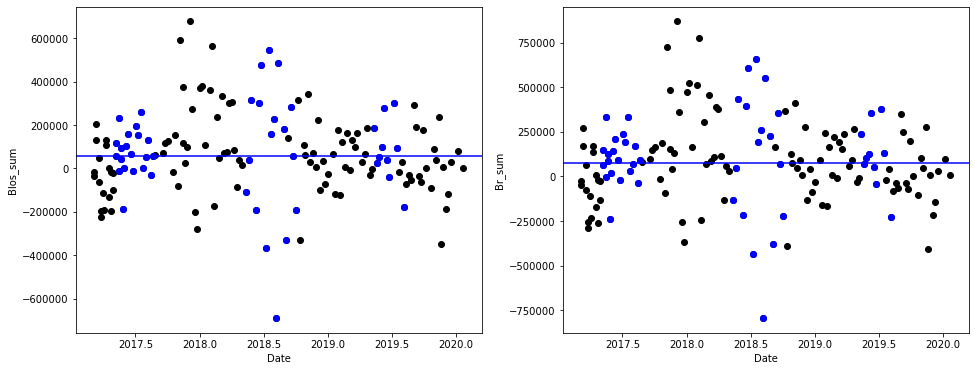

In [484]:
median_Blos_sum = np.median(ts['Blos_sum'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(ts['t'].decimalyear, ts['Blos_sum'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['Blos_sum'][fast], 'bo')
ax1.axhline(median_Blos_sum, c='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Blos_sum')

median_Br_sum = np.median(ts['Br_sum'])
ax2.plot(ts['t'].decimalyear, ts['Br_sum'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['Br_sum'][fast], 'bo')
ax2.axhline(median_Br_sum, c='b')
ax2.set_xlabel('Date')
ax2.set_ylabel('Br_sum')
fig.savefig("ts_sumB.pdf", bbox_inches='tight')

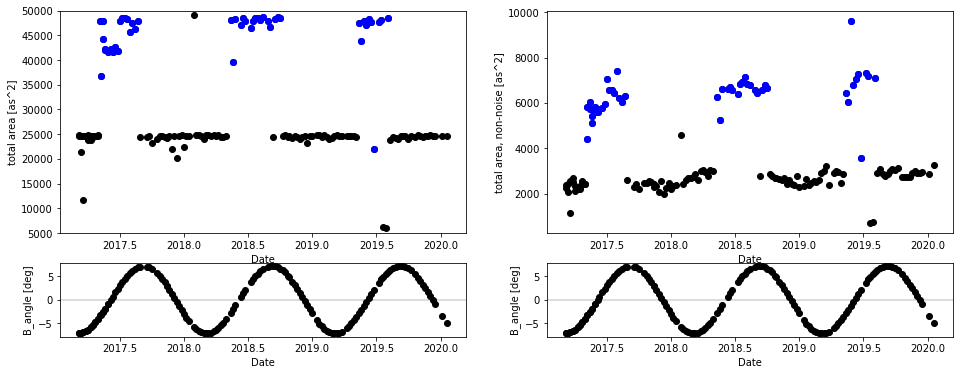

In [485]:
fig, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(2, 2, figsize=(16,6), gridspec_kw={'height_ratios':(3,1)})
ax1.plot(ts['t'].decimalyear, ts['area'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['area'][fast], 'bo')
ax1.set_xlabel('Date')
ax1.set_ylabel('total area [as^2]')
ax1.set_ylim(5000, 50000)
ax1b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax1b.axhline(0, c='lightgray', zorder=-1)
ax1b.set_ylabel("B_angle [deg]")
ax1b.set_xlabel("Date")

ax2.plot(ts['t'].decimalyear, ts['area_ok'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['area_ok'][fast], 'bo')
ax2.set_xlabel('Date')
ax2.set_ylabel('total area, non-noise [as^2]')
ax2b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax2b.axhline(0, c='lightgray', zorder=-1)
ax2b.set_ylabel("B_angle [deg]")
ax2b.set_xlabel("Date")
fig.savefig("ts_area.pdf", bbox_inches='tight')

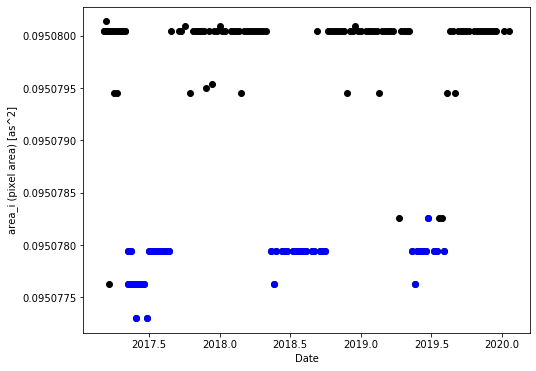

In [486]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ts['t'].decimalyear, ts['area_i'], 'ko')
ax.plot(ts['t'][fast].decimalyear, ts['area_i'][fast], 'bo')
ax.set_xlabel('Date')
ax.set_ylabel('area_i (pixel area) [as^2]')
fig.savefig("ts_area_i.pdf", bbox_inches='tight')

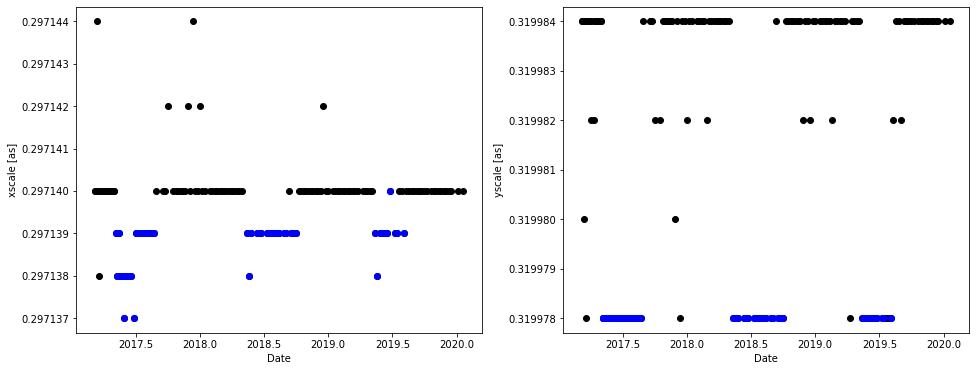

In [487]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(ts['t'].decimalyear, ts['xscale'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['xscale'][fast], 'bo')
ax1.set_xlabel('Date')
ax1.set_ylabel('xscale [as]')

ax2.plot(ts['t'].decimalyear, ts['yscale'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['yscale'][fast], 'bo')
ax2.set_xlabel('Date')
ax2.set_ylabel('yscale [as]')
fig.savefig("ts_scale.pdf", bbox_inches='tight')

Text(0, 0.5, 'Ny pixels')

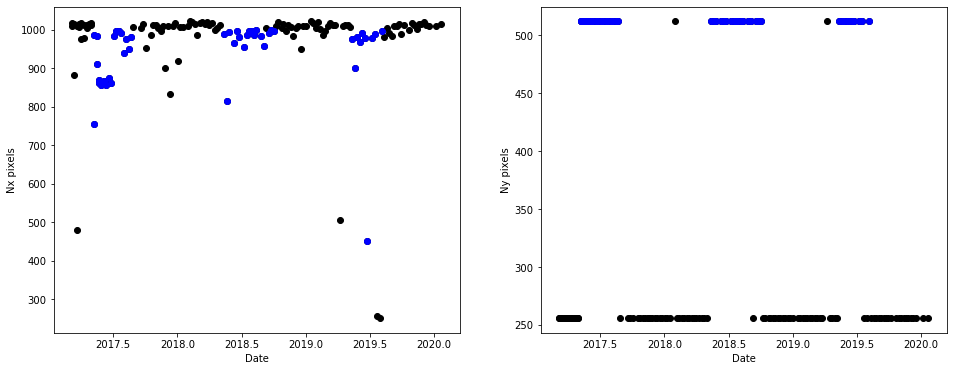

In [488]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(ts['t'].decimalyear, ts['Nx'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['Nx'][fast], 'bo')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nx pixels')

ax2.plot(ts['t'].decimalyear, ts['Ny'], 'ko')
ax2.plot(ts['t'][fast].decimalyear, ts['Ny'][fast], 'bo')
#ax2.set_ylim(510, 520)
ax2.set_xlabel('Date')
ax2.set_ylabel('Ny pixels')

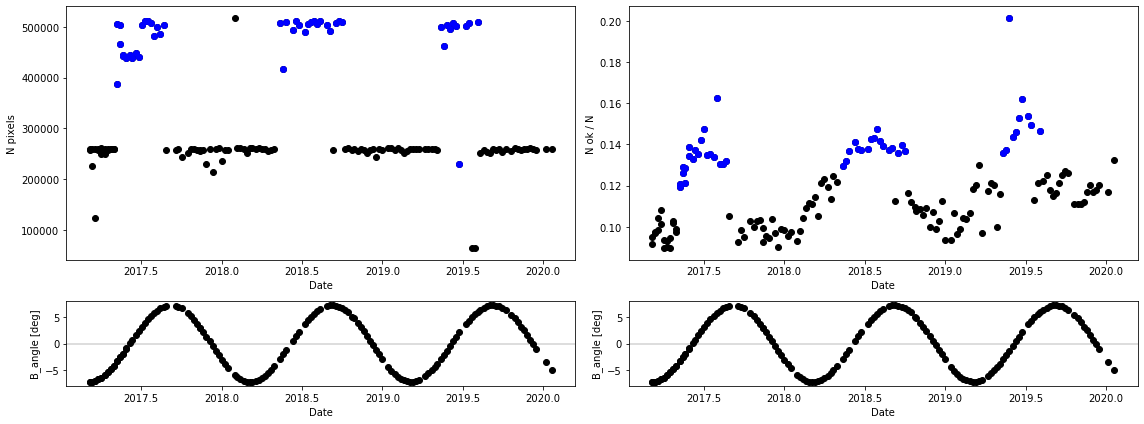

In [489]:
fig, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(2, 2, figsize=(16,6), gridspec_kw={'height_ratios':(3,1)})
ax1.plot(ts['t'].decimalyear, ts['N'], 'ko')
ax1.plot(ts['t'][fast].decimalyear, ts['N'][fast], 'bo')
ax1.set_xlabel('Date')
ax1.set_ylabel('N pixels')
ax1b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax1b.axhline(0, c='lightgray', zorder=-1)
ax1b.set_ylabel("B_angle [deg]")
ax1b.set_xlabel("Date")

ok_ratio = ts['Nok']/ts['N']
ax2.plot(ts['t'].decimalyear, ok_ratio, 'ko')
ax2.plot(ts['t'][fast].decimalyear, ok_ratio[fast], 'bo')
ax2.set_xlabel('Date')
ax2.set_ylabel('N ok / N')
ax2b.plot(ts['t'].decimalyear, ts['b_angle'], 'ko')
ax2b.axhline(0, c='lightgray', zorder=-1)
ax2b.set_ylabel("B_angle [deg]")
ax2b.set_xlabel("Date")
fig.tight_layout()
fig.savefig("ts_N.pdf", bbox_inches='tight')

# Notes on noise

 * Fast maps have larger pixels due to slit-direction summing, and therefore have lower noise per pixel.
 * Fast maps have larger slit-step sizes, Nx is half as large for fast maps.
 * Fast maps have a 2x larger field-of-view in the slit direction than the normal maps.  However, because of the slit summing the Ny pixels is the same for both maps.
 * The total number of pixels for fast maps is about half that of normal maps.
 * The total area of fast maps is slightly less than twice that of normal maps.
 * The mode of the $|B|$ histogram is lower for fast maps
   * Explanation: Because noisy pixels are inverted to higher field strengths, pushing the mode upward for normal maps.
 * As the B-angle increases (north points to observer) the $|B|$ mode decreases (more small fields).
   * Explanation:  As the B-angle gets larger, the north hemisphere is inclined toward the observer.  This produces three effects:
     1. Observed pixels are further from the limb.
     2. Pixels contain a smaller physical area on the Sun.
     3. Assuming radial field, the LOS component of the field increases.  
   * Item 2 must dominate, resulting in higher true resolution and a larger number of pixels with small field.
 * Setting a fixed threshold larger than the typical $|B|$ mode of a normal map, the follwing effects are observed:
   * The fraction of "good" pixels is larger (by about factor 2) for the normal maps than the fast maps.
     * Explanation: the mode is lower for the fast maps, therefore more pixels are marked bad.
   * The fraction of "good" pixels varies with the B-angle: as B-angle increases, Nok/N increases.
     * Explanation 1: as the B-angle increases, the mode of $|B|$ decreases, resulting in a **smaller** Nok/N. <span style='color:red'>**WTF**</span>
     * Explanation 2: as the B-angle increases, the LOS component of radial B fields increases, resulting in larger Stokes V signals and therefore larger Nok/N.
   * The total area of "good" pixels is a continuous time series (no jumps for fast/normal map transition).
     * Explanation: while the fraction of good pixels is about half, the total area is about double.
 * The total unsigned flux of a normal map is higher than for a fast map
   * Explanation: with unsigned flux the noise adds, and there are more pixels in a normal map than a fast map
     * Correlary: even with a high noise threshold, there is still noise!
   

# Notes on trends

 * There appears to be a slight rising trend in total unsigned flux (must consider normal/fast maps independently due to discontinuity
 * There appears to be an very small rising trend in mean unsigned flux.  Normal/fast maps are not obviously discontinuous, but there are very strange variations in the fast maps
 * There does not appear to be a trend in net flux (mean($B$)).
   * The time-average of mean($B$) is positive, consistent with either:
     * A positive leading polarity for emerging bipoles and a longer-lived leading polarity.  This is consistent with cycle 25 emerging toroidal flux (odd cycle => positive north).
     * Cycle 24 following polarity (positive) transported toward the pole, as observed in magnetic butterfly diagrams.
 * There is a clear rising trend in the total area of non-noise pixels, continuous across both normal/fast maps.  This is consistent with the idea that the activity is increasing.
 * There is a rising trend in fraction of non-noise pixels (Nok/N), discontinous across normal/fast maps.

### General Notes

 * **DONE.** Rebecca: Multiply $B_{\rm LOS}$ by filling factor $\alpha$ to create flux $\Phi_{\rm LOS}$.  This reduces the "noise" in the low flux areas, improving the fidelity and contrast of the flux regions.
 * Rebecca: Obtaining $B_r$ from these Quiet Sun regions is probably hopeless, but might check with KD Leka for another opinion.
 * Rebecca: Check with Derek Lamb (SwRI) for feature identification code or references in the literature.
   * My idea: use DBSCAN.  Might be an innovation?  [Available in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

### TODO

 * Validate fits file pointing with repoint file pointing
 * Iterate over all observations, make time series of aggregate quantities
   * Unisgned flux
   * Flux imbalance
   * Average feature size
 * Bin time-series in time to get finer precision to find of potential trends
 * Make movie of B (vector B?)
 * Average over longitude and plot limited butterfly diagram
 * Compare to equatorial observations (disk center synoptic)
 * Investigate inclination
 * Include IRIS observations
 * Include AIA/BP observations for context (band position)
 * Check thresholding horizontal field at ~150 G (Bsin(theta))
   * 2 noise thresholds for different pixel scale averaging?
 * Think about if ~20 as pointing error matters...
 * Intensity = B_0 + B_1 (source function & gradient)
 * LOS velocity dynamics around BPs?
 * Once features are identified, calculate net separation and consider supergranular origin